In [ ]:
!pip install datasets
!pip install git+https://github.com/huggingface/transformers.git
!pip install shap
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.0 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-x2_0oqk3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-x2_0oqk3
  Resolved https://github.com/huggingface/transformers.git to commit 7ee995fd9c692761c4601ddbffa2ac2ec9f27b0b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import os
import transformers
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification,  AutoTokenizer, EvalPrediction,pipeline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from datasets import load_dataset, Dataset as D
from typing import List, Optional
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score,roc_auc_score
from collections import defaultdict
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
batch_size = 16
MAX_LEN = 160
RANDOM_SEED = 16
data_set = 'dair-ai/emotion'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
dataset= load_dataset(data_set)


In [ ]:
ids = {
    0: "sadness",
    1: "joy" ,
    2: "love" ,
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
MAX_LEN = float("-inf")

for txt in dataset["train"]["text"]:
    tokens = tokenizer.encode(txt,truncation=True, max_length=512)
    curr = len(tokens)
    MAX_LEN = max(curr,MAX_LEN)

In [ ]:
MAX_LEN

In [ ]:
def one_hot_encode(arr):

    num_classes = max(arr) + 1

    one_hot = np.zeros((len(arr), num_classes), dtype=int)
    one_hot[np.arange(len(arr)), arr] = 1

    return one_hot.astype(float)



In [ ]:
arr = [1,2,3,4,5,8]

In [ ]:
a = one_hot_encode(arr)

In [ ]:
def preprocess_data(examples):
  # take a batch of texts
    text = examples['text']


    arr = one_hot_encode(examples['label'])




    encoding = tokenizer( text ,
                            add_special_tokens=True,
                            max_length= MAX_LEN,
                            return_token_type_ids=True,
                            pad_to_max_length=True,
                            return_attention_mask=True,
                            return_tensors='pt',)







    output = {"input_ids": encoding["input_ids"],
                'token_type_ids': encoding['token_type_ids'],
                'attention_mask': encoding['attention_mask'],
                'labels' : arr}

    return output



In [ ]:
data = dataset.map(preprocess_data,batched=True,remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
label2id = {
    "sadness":0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}


id2label = {0: "sadness",
            1: "joy" ,
            2: "love" ,
            3: "anger",
            4: "fear",
            5: "surprise"
}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(id2label),
                                                            id2label=id2label,
                                                           label2id=label2id,
  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.35.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# def multi_label_metrics(predictions, labels, threshold=0.5):
#     # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
#     sigmoid = torch.nn.Sigmoid()
#     probs = sigmoid(torch.Tensor(predictions))
#     # next, use threshold to turn them into integer predictions
#     y_pred = np.zeros(probs.shape)
#     y_pred[np.where(probs >= threshold)] = 1
#     # finally, compute metrics
#     y_true = labels
#     f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
#     roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
#     accuracy = accuracy_score(y_true, y_pred)
#     # return as dictionary
#     metrics = {'f1': f1_micro_average,
#                'roc_auc': roc_auc,
#                'accuracy': accuracy}
#     return metrics

# def compute_metrics(p: EvalPrediction):
#     preds = p.predictions[0] if isinstance(p.predictions,
#             tuple) else p.predictions
#     result = multi_label_metrics(
#         predictions=preds,
#         labels=p.label_ids)
#     return result


# def compute_metrics(p):

#     predicted_labels = np.argmax(p.predictions, axis=1)

#     preds = [0 for i in range(0,6)]

#     preds[predicted_labels] = 1

#     true_labels = p.label_ids

#     accuracy = accuracy_score(true_labels, preds)

#     f1 = f1_score(true_labels, preds, average= None)


#     recall = recall_score(true_labels, preds ,average=None)

#     return {"accuracy": accuracy, "f1_score": f1, "recall_score": recall}


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/icse-rail/Models/bert",
        evaluation_strategy = "epoch",
        save_strategy= "epoch",
        learning_rate = 2e-4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=2,
        weight_decay = 0.01,
        save_total_limit=2,
        load_best_model_at_end = True,
        metric_for_best_model = "macro-f1"

)


    # output_dir="/content/drive/MyDrive/Chatbot/Output_GPT_2",
    # overwrite_output_dir=True, #overwrite the content of the output directory
    # num_train_epochs=10, # number of training epochs
    # per_device_train_batch_size=2, # batch size for training
    # per_device_eval_batch_size=20,  # batch size for evaluation
    # load_best_model_at_end=True,
    # logging_steps=40,
    # log_level='info',
    # # evaluation_strategy='no',
    # # save_strategy='no',
    # save_total_limit = 1,



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    tokenizer=tokenizer,
    # compute_metrics= compute_metrics
)



In [ ]:
trainer.evaluate()

{'eval_loss': 0.06739213317632675,
 'eval_runtime': 12.2861,
 'eval_samples_per_second': 162.785,
 'eval_steps_per_second': 40.696}

In [ ]:
trainer.train()

Step,Training Loss
500,0.073700
1000,0.058500
1500,0.064500
2000,0.058600
2500,0.046700
3000,0.054600
3500,0.062800
4000,0.070500
4500,0.045700
5000,0.048100


TrainOutput(global_step=8000, training_loss=0.049990491151809695, metrics={'train_runtime': 796.1943, 'train_samples_per_second': 40.191, 'train_steps_per_second': 10.048, 'total_flos': 1430717745024000.0, 'train_loss': 0.049990491151809695, 'epoch': 2.0})

In [ ]:
trainer.save_model()

In [ ]:

loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/icse-rail/Models/bert',
                                                           problem_type="multi_label_classification",
                                                           num_labels=6,
                                                           id2label=id2label,
                                                           label2id=label2id)

In [ ]:
trained_model = pipeline("text-classification", model=loaded_model, tokenizer=tokenizer)

In [ ]:
val_text = dataset["validation"]["text"]

In [ ]:
type(val_text)

list

In [ ]:
explainer = shap.Explainer(trained_model )


In [ ]:
shap_values = explainer(val_text[:10])

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 1/10 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 4/10 [01:26<00:53,  8.96s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 5/10 [01:37<00:48,  9.79s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 6/10 [02:05<01:04, 16.20s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 7/10 [02:37<01:03, 21.32s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [03:07<00:48, 24.24s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 9/10 [03:29<00:23, 23.50s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 10/10 [03:41<00:00, 19.99s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [03:52, 23.25s/it]


In [ ]:
res = trained_model(val_text[:10])

In [ ]:
res

[{'label': 'sadness', 'score': 0.9985465407371521},
 {'label': 'sadness', 'score': 0.9985594153404236},
 {'label': 'love', 'score': 0.9461309313774109},
 {'label': 'anger', 'score': 0.9973076581954956},
 {'label': 'joy', 'score': 0.9988151788711548},
 {'label': 'joy', 'score': 0.9986099004745483},
 {'label': 'joy', 'score': 0.9988968372344971},
 {'label': 'joy', 'score': 0.998760461807251},
 {'label': 'joy', 'score': 0.9989333748817444},
 {'label': 'sadness', 'score': 0.9985505938529968}]

In [ ]:
shap_values.shape

(10, None, 6)

In [ ]:
def data(res,shap_values):

    preds = []
    results = []

    for i in range(0,len(res)):

        pred = res[i]["label"]
        preds.append(pred)

        s = shap_values[i, :, pred]

        results.append(s)

    return results, preds




In [ ]:
results, preds = data(res,shap_values)

In [ ]:
results[0].shape

(17,)

In [ ]:
results[0]

.values =
array([ 0.00000000e+00, -6.99609518e-06,  1.63706020e-04, -3.13501805e-05,
        4.99372665e-01, -6.07706606e-05,  4.98800774e-01,  2.29903497e-04,
        7.16354698e-05,  3.96370888e-06, -5.58793545e-08,  1.59814954e-06,
        9.98377800e-07,  3.72529030e-08,  1.63912773e-07,  2.68220901e-07,
        0.00000000e+00])

.base_values =
0.0

.data =
array(['', 'im ', 'feeling ', 'quite ', 'sad ', 'and ', 'sorry ', 'for ',
       'myself ', 'but ', 'ill ', 'snap ', 'out ', 'of ', 'it ', 'soon',
       ''], dtype='<U8')

In [ ]:
shap.plots.text(shap_values[3])

In [ ]:
shap_values2 = explainer(val_text[15:16])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:32, 92.06s/it]               


In [ ]:
val_text[15:16]

['i never stop feeling thankful as to compare with others i considered myself lucky because i did not encounter ruthless pirates and i did not have to witness the slaughter of others']

In [ ]:
res = trained_model(val_text[15:16])

In [ ]:
pred = res[0]["label"]

In [ ]:
pred

'joy'

In [ ]:
shap.plots.text(shap_values2[0, :, pred])

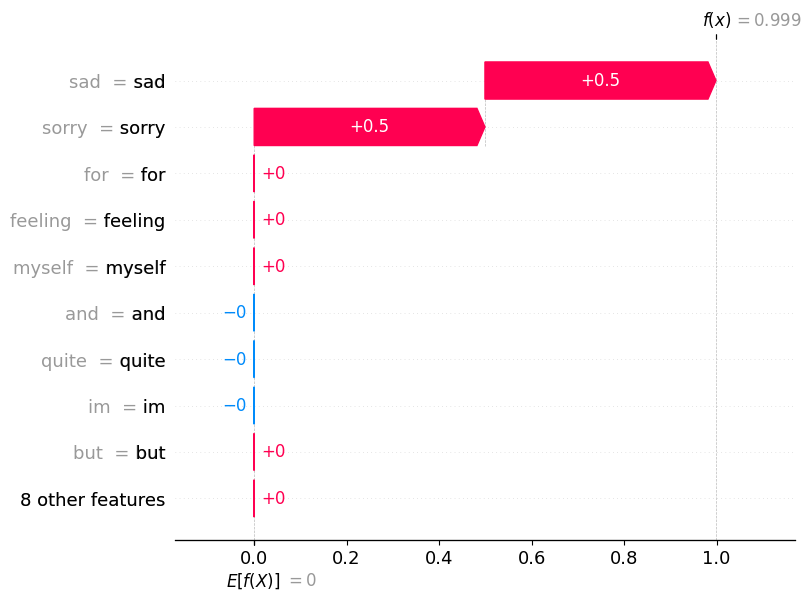

In [ ]:
shap.plots.waterfall(results[0])

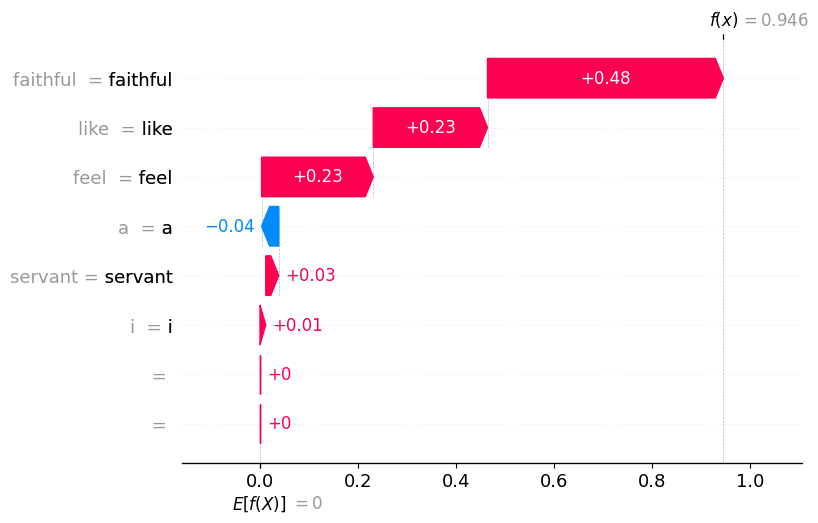

In [ ]:
shap.plots.waterfall(results[2])

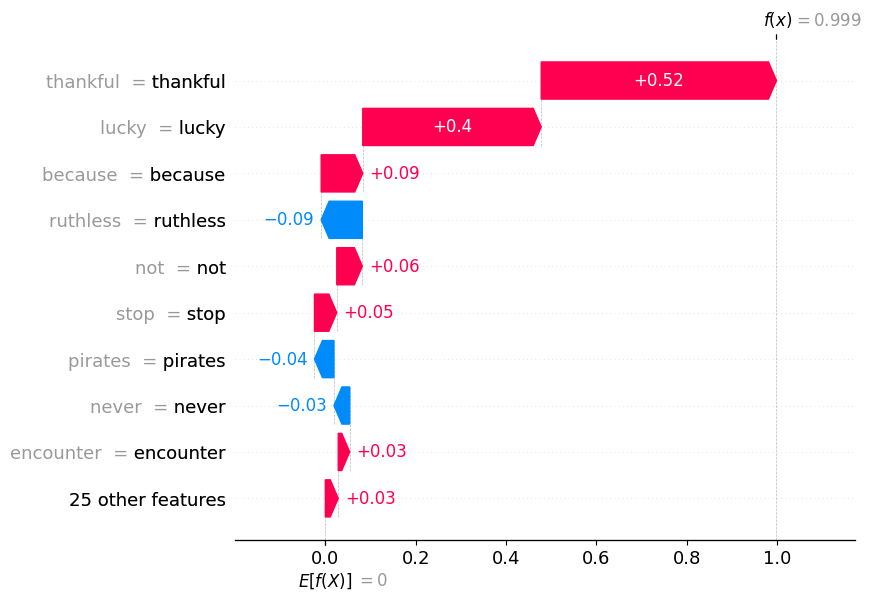

In [ ]:
shap.plots.waterfall(shap_values2[0, :, pred])

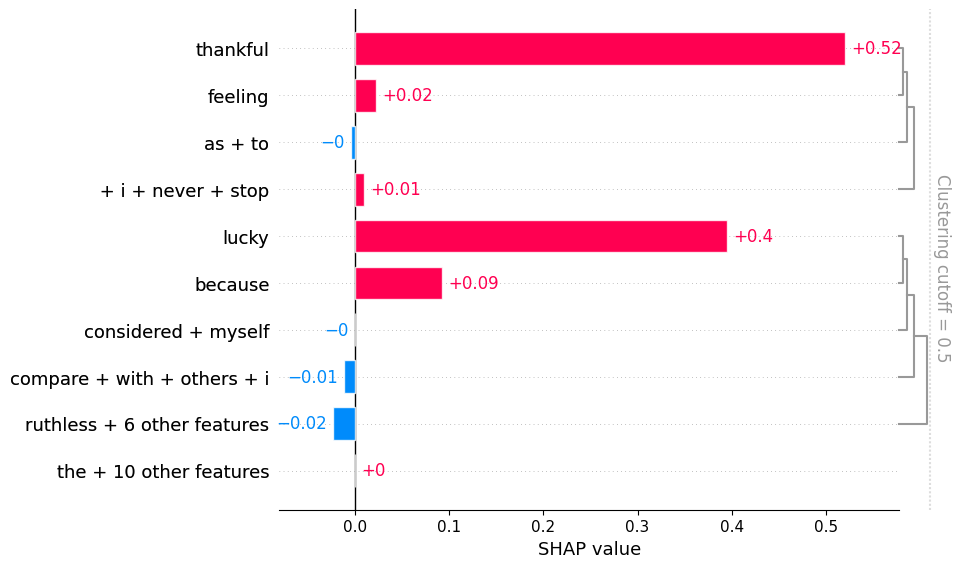

In [ ]:
shap.plots.bar(shap_values2[0, :, pred])

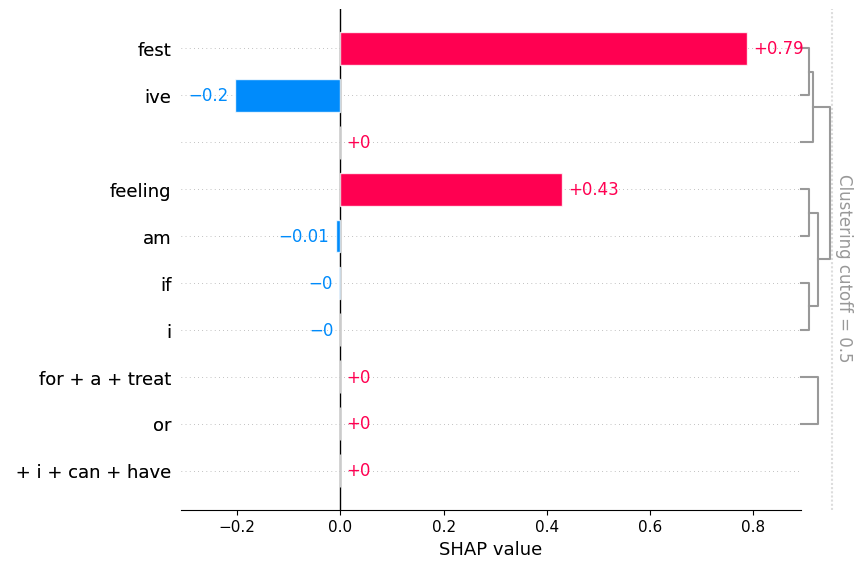

In [ ]:
shap.plots.bar(results[4])

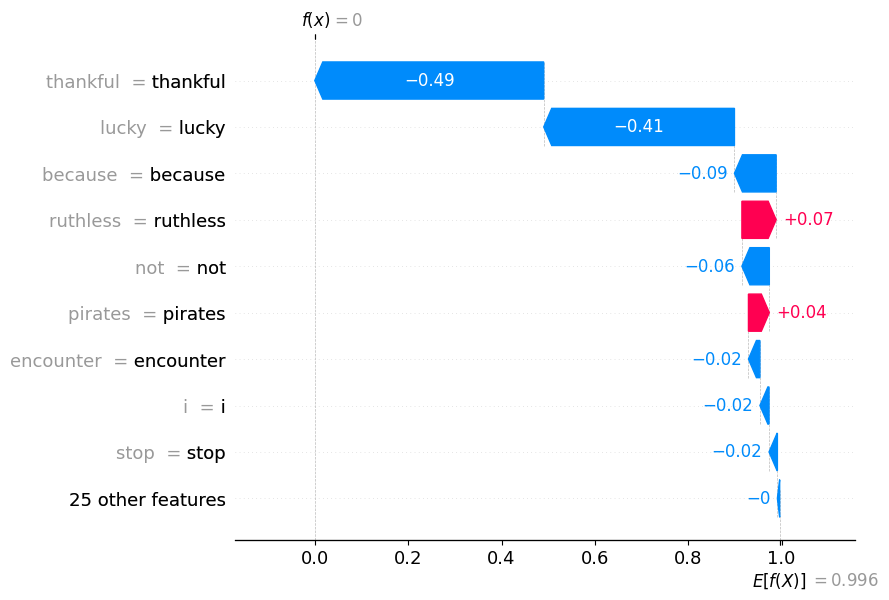

In [ ]:
shap.plots.waterfall(shap_values2[0, :, "anger"])

In [ ]:
d = shap_values2[0, :, pred]

In [ ]:
d.shape

(34,)

In [ ]:
d

.values =
array([ 6.68689609e-07, -4.94943373e-03, -3.48928329e-02,  4.93803527e-02,
        2.18394268e-02,  5.20991260e-01, -1.14423521e-02,  6.45438582e-03,
       -4.39277757e-03, -4.71218210e-03, -5.08353207e-03,  2.56012101e-03,
       -2.88505666e-03,  2.54191831e-03,  3.95158118e-01,  9.21442360e-02,
        1.86674246e-02,  1.21802563e-02,  5.66275358e-02,  2.54213433e-02,
       -9.11958842e-02, -4.31343327e-02, -2.31339978e-03, -1.12503767e-06,
       -1.12503767e-06, -4.69386578e-07, -4.69386578e-07,  5.43892384e-07,
        5.43892384e-07,  2.79396772e-06,  2.79396772e-06, -1.29143397e-07,
       -1.29143397e-07, -1.29143397e-07])

.base_values =
0.0

.data =
array(['', 'i ', 'never ', 'stop ', 'feeling ', 'thankful ', 'as ', 'to ',
       'compare ', 'with ', 'others ', 'i ', 'considered ', 'myself ',
       'lucky ', 'because ', 'i ', 'did ', 'not ', 'encounter ',
       'ruthless ', 'pirates ', 'and ', 'i ', 'did ', 'not ', 'have ',
       'to ', 'witness ', 'the ', 'sl

In [ ]:
val = d.values

text = d.data

arr = []

for i,j in zip(val,text):

    arr.append((i,j))

arr2 = arr[:]

arr.sort(reverse= True)


print("The prediction is influenced by the words: ", arr[0][1], " " , arr[1][1])

print("The prediction is not influenced by the words: ", arr[-1][1], " " , arr[-2][1])

The prediction is influenced by the words:  thankful    lucky 
The prediction is not influenced by the words:  ruthless    pirates 


In [ ]:
arr2

[(6.686896085739136e-07, ''),
 (-0.004949433729052544, 'i '),
 (-0.03489283286035061, 'never '),
 (0.04938035272061825, 'stop '),
 (0.021839426830410957, 'feeling '),
 (0.5209912601858377, 'thankful '),
 (-0.011442352086305618, 'as '),
 (0.006454385817050934, 'to '),
 (-0.004392777569591999, 'compare '),
 (-0.004712182097136974, 'with '),
 (-0.0050835320726037025, 'others '),
 (0.0025601210072636604, 'i '),
 (-0.002885056659579277, 'considered '),
 (0.002541918307542801, 'myself '),
 (0.39515811763703823, 'lucky '),
 (0.09214423596858978, 'because '),
 (0.01866742462984153, 'i '),
 (0.012180256258164133, 'did '),
 (0.05662753579339811, 'not '),
 (0.02542134334466287, 'encounter '),
 (-0.09119588424939484, 'ruthless '),
 (-0.043134332723206, 'pirates '),
 (-0.002313399776106789, 'and '),
 (-1.125037670135498e-06, 'i '),
 (-1.125037670135498e-06, 'did '),
 (-4.6938657760620117e-07, 'not '),
 (-4.6938657760620117e-07, 'have '),
 (5.438923835754395e-07, 'to '),
 (5.438923835754395e-07, 'wi

In [ ]:

def plot(d):

    val = d.values

    text = d.data



    # Create a horizontal bar plot
    fig, ax = plt.subplots(figsize=(10, 12))
    bars = ax.barh(text, val, color='skyblue')

    # Customize the plot
    ax.set_xlabel('Values')
    # ax.set_title('Bar Plot for List "a" with Labels from List "b"')

    # Display labels horizontally for better readability
    ax.set_yticklabels(text, fontsize=8)

    # Add values on the right of the bars
    # for bar, value in zip(bars, a):
    #     ax.text(value, bar.get_y() + bar.get_height() / 2, f'{value:.3f}', va='center')

    plt.tight_layout()
    plt.show()

FixedFormatter should only be used together with FixedLocator


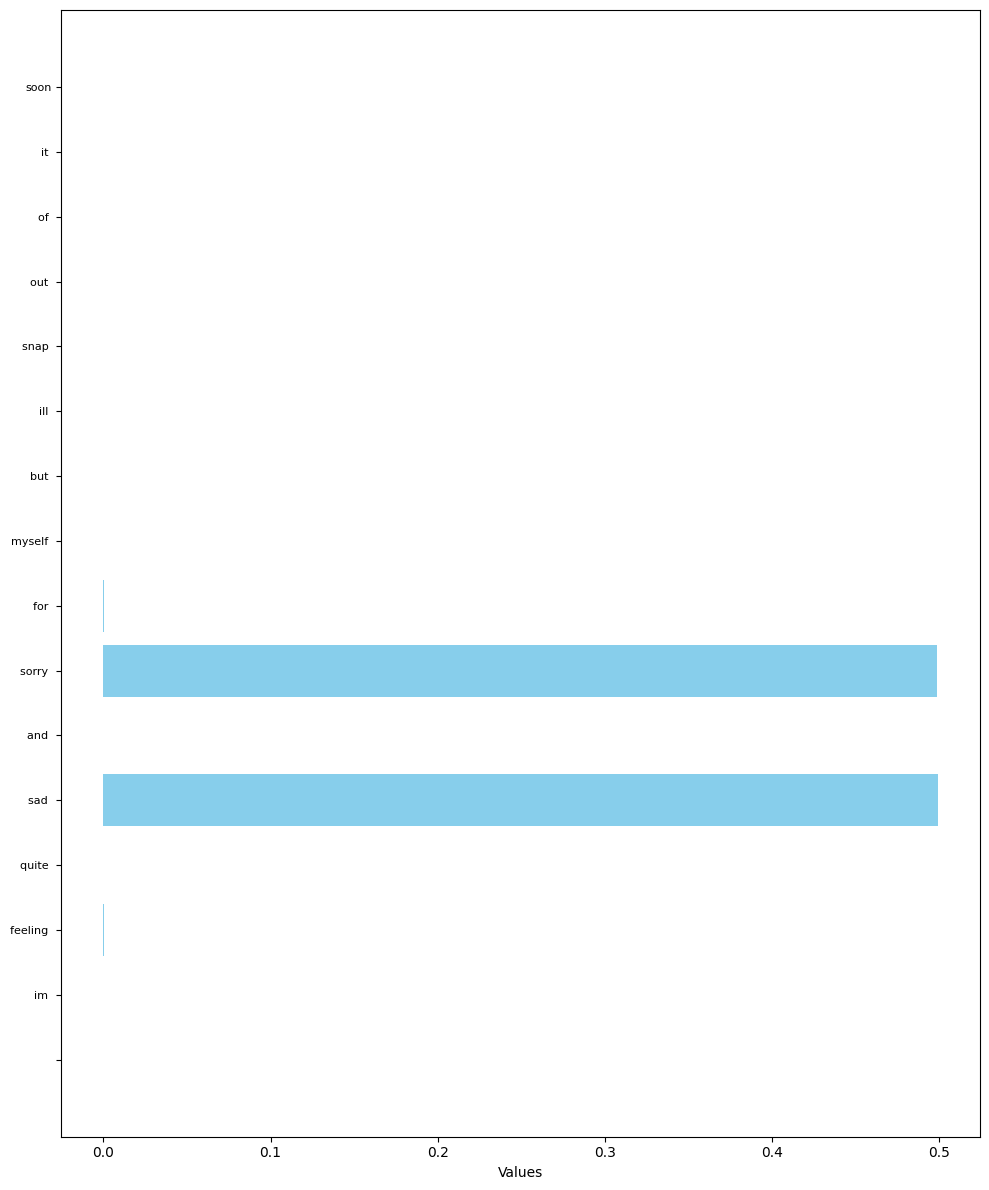

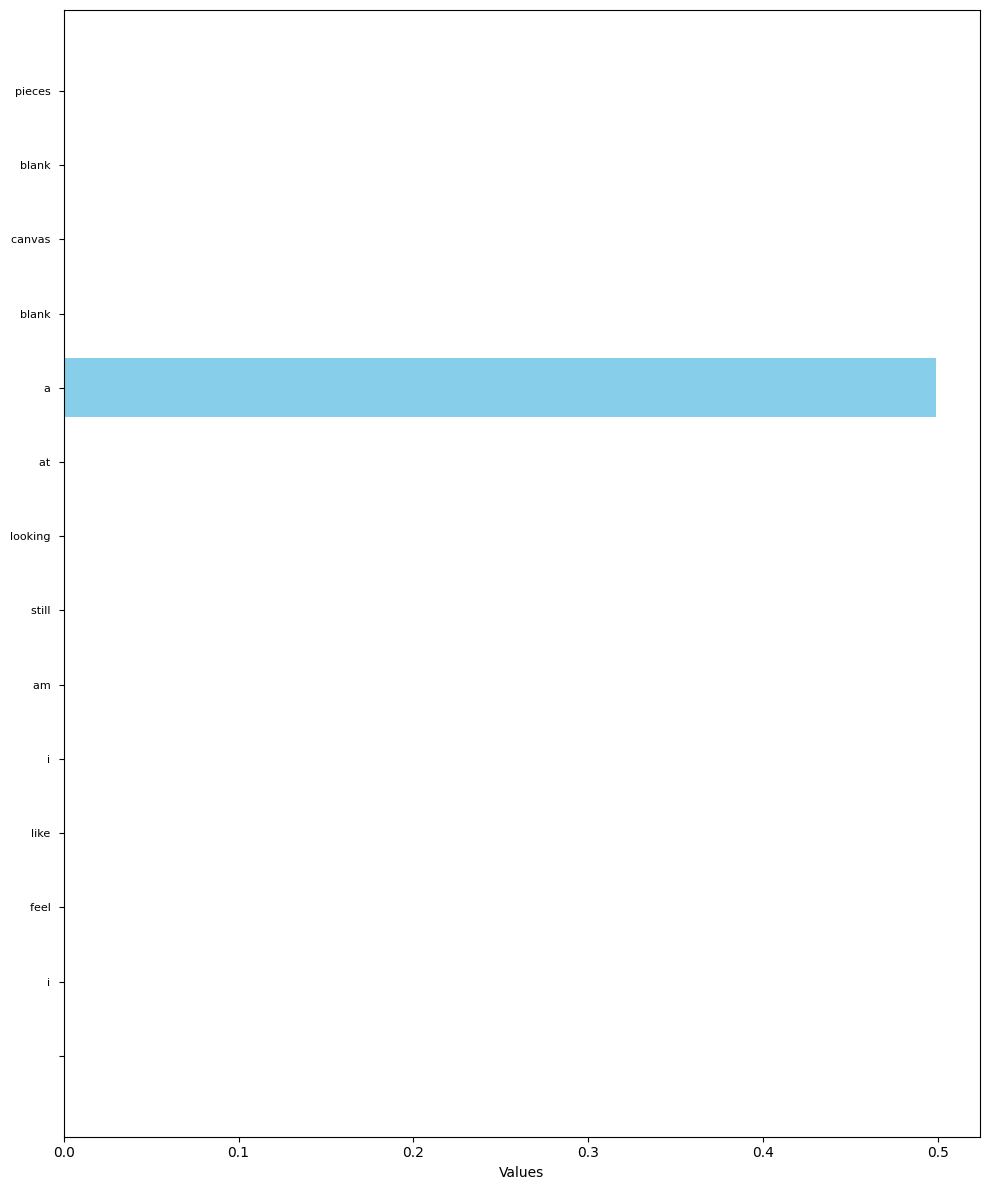

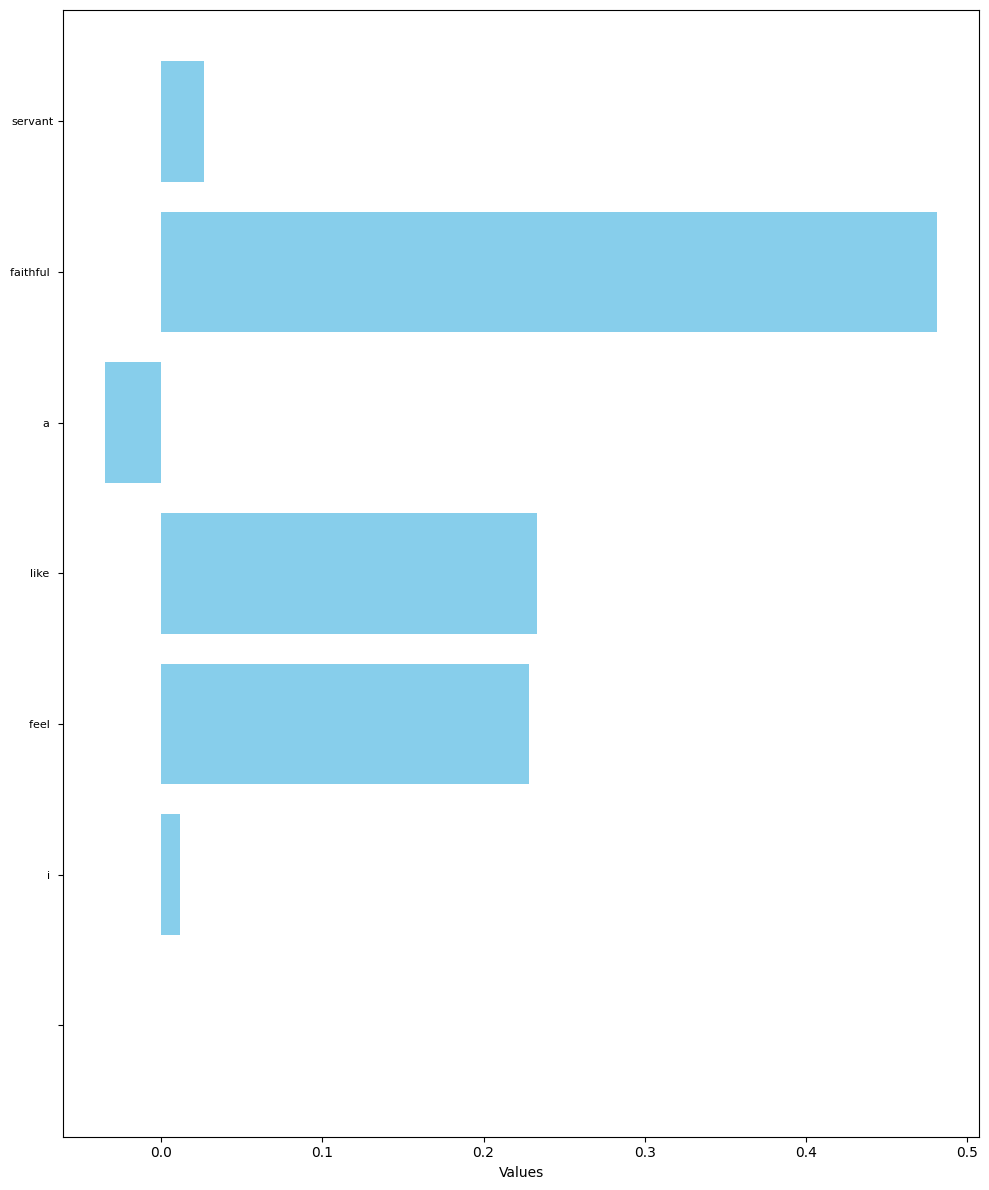

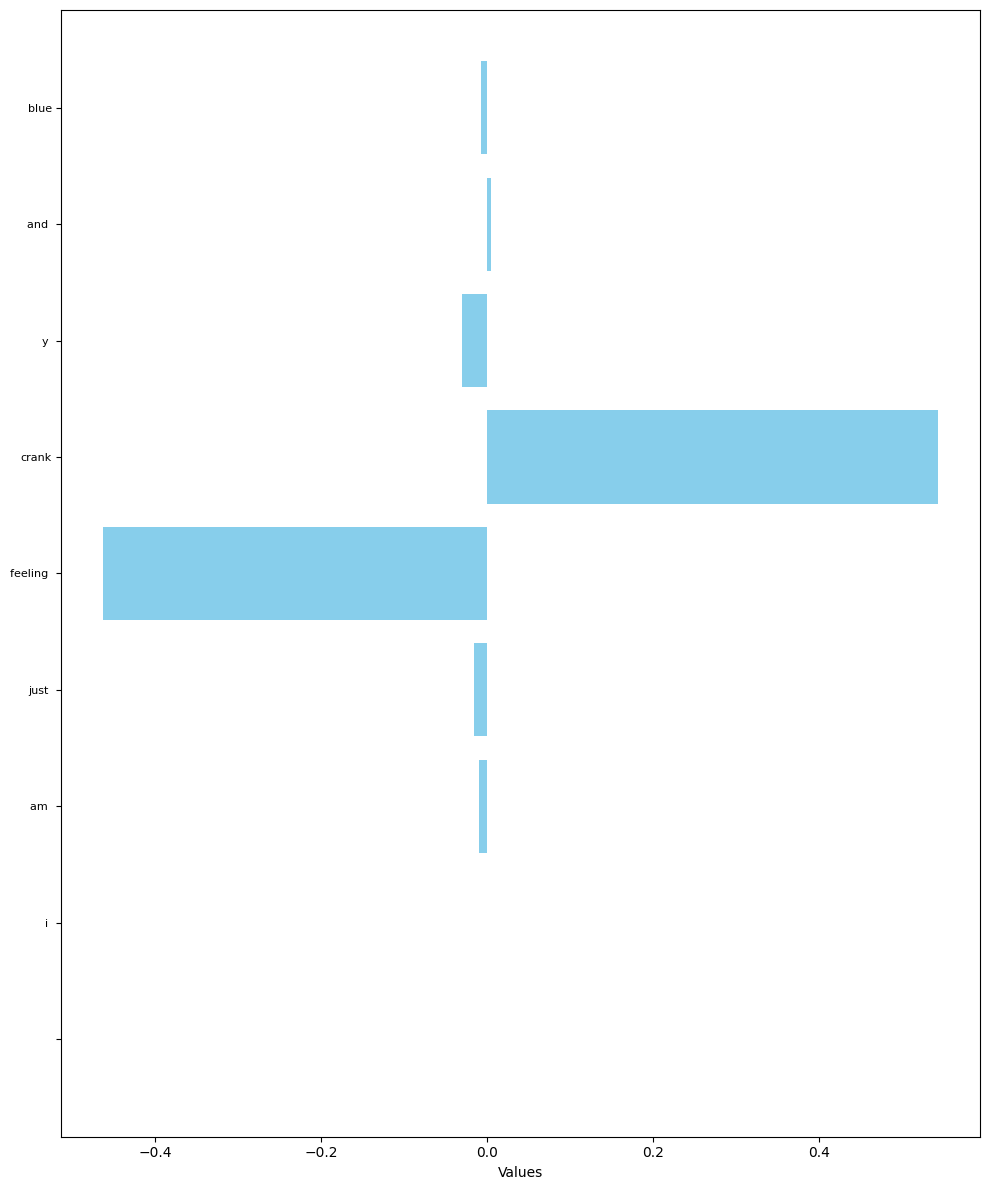

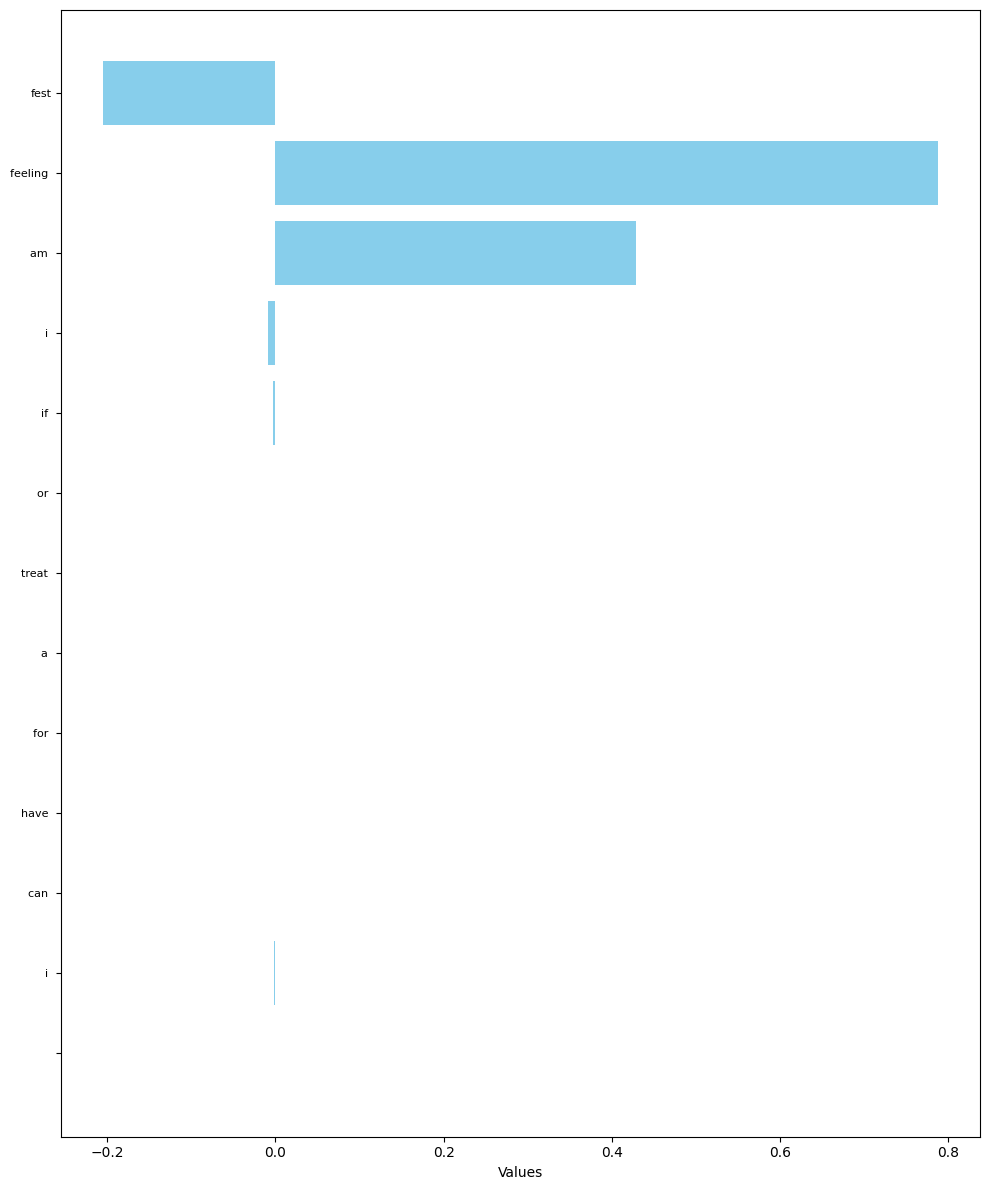

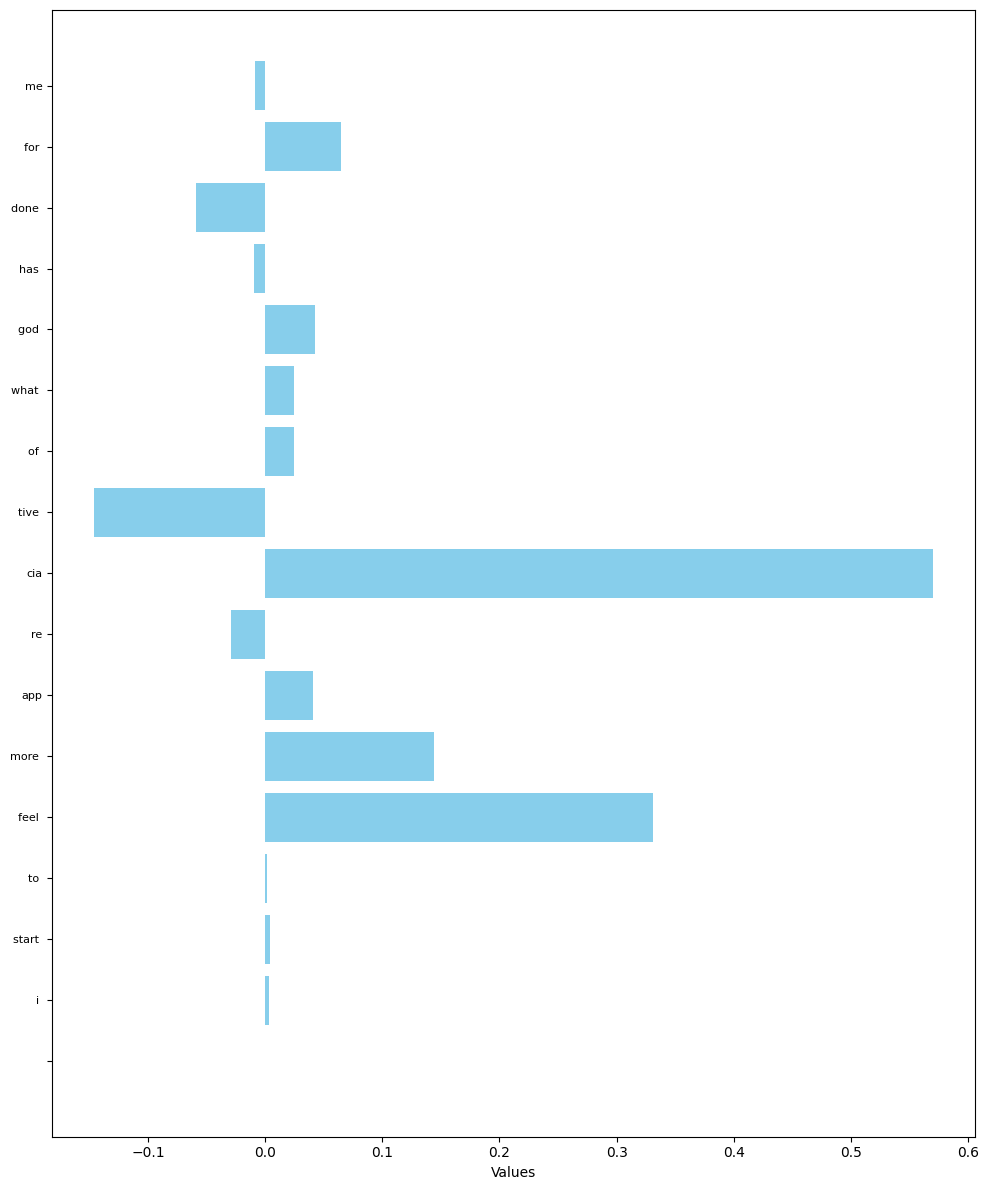

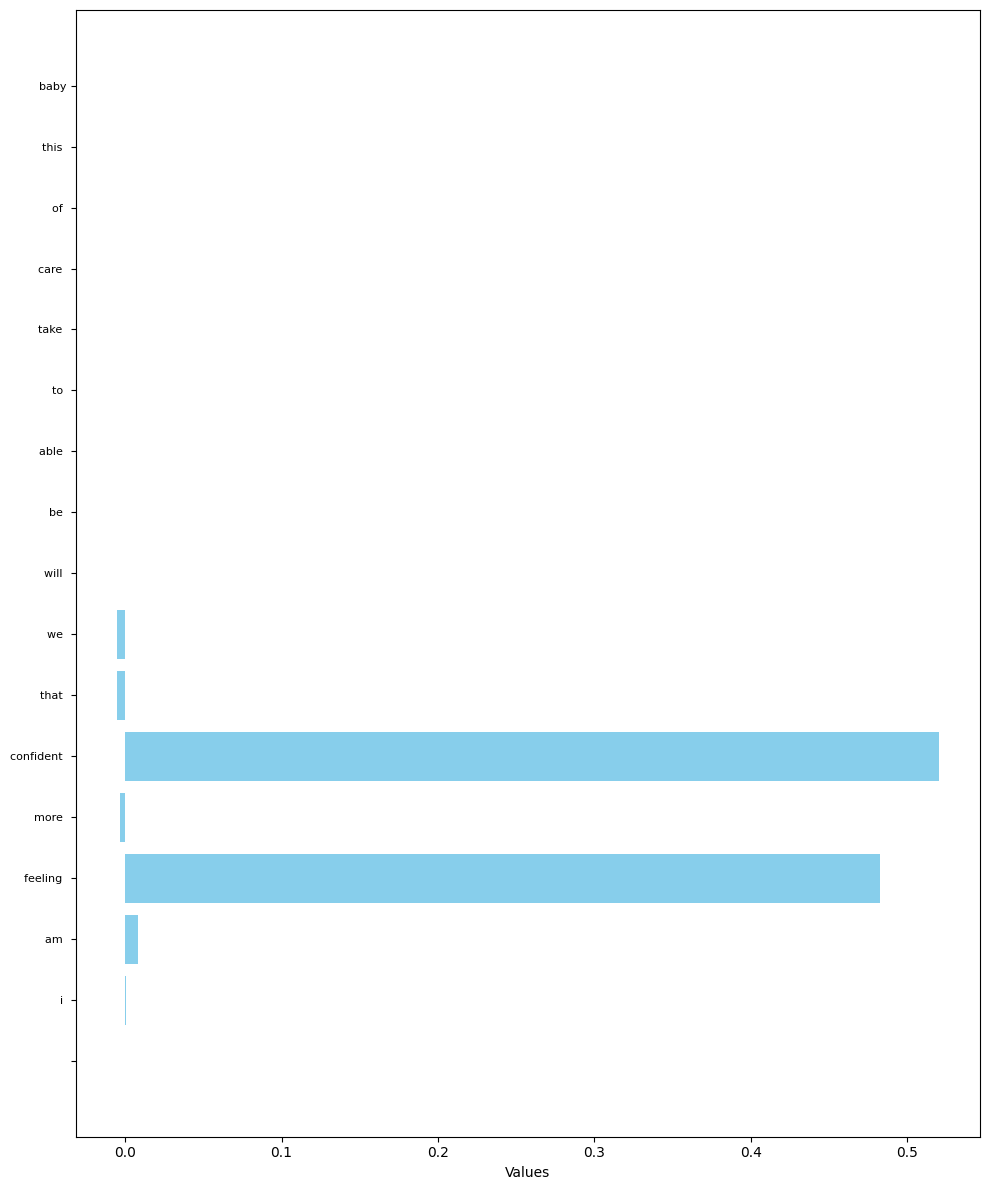

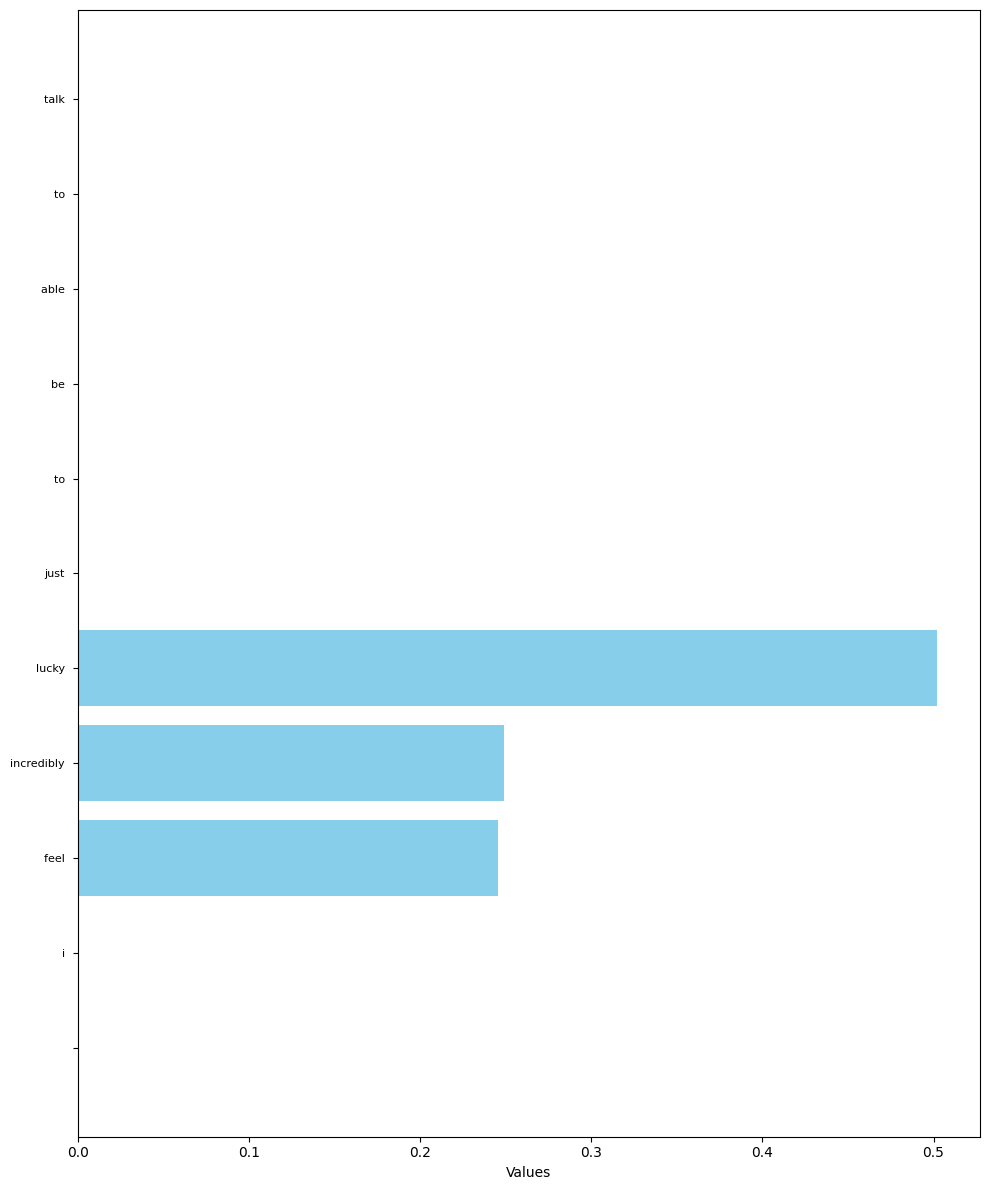

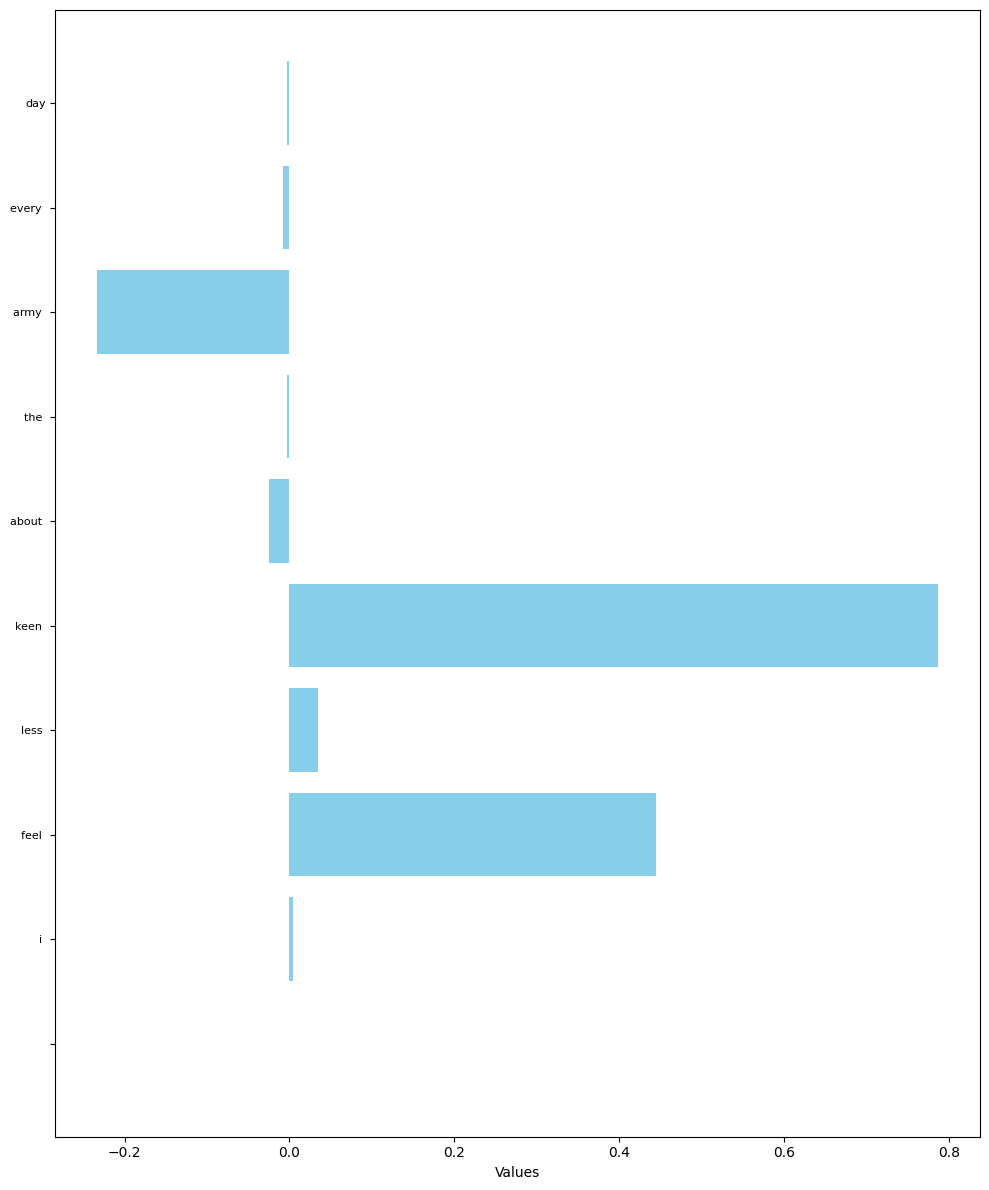

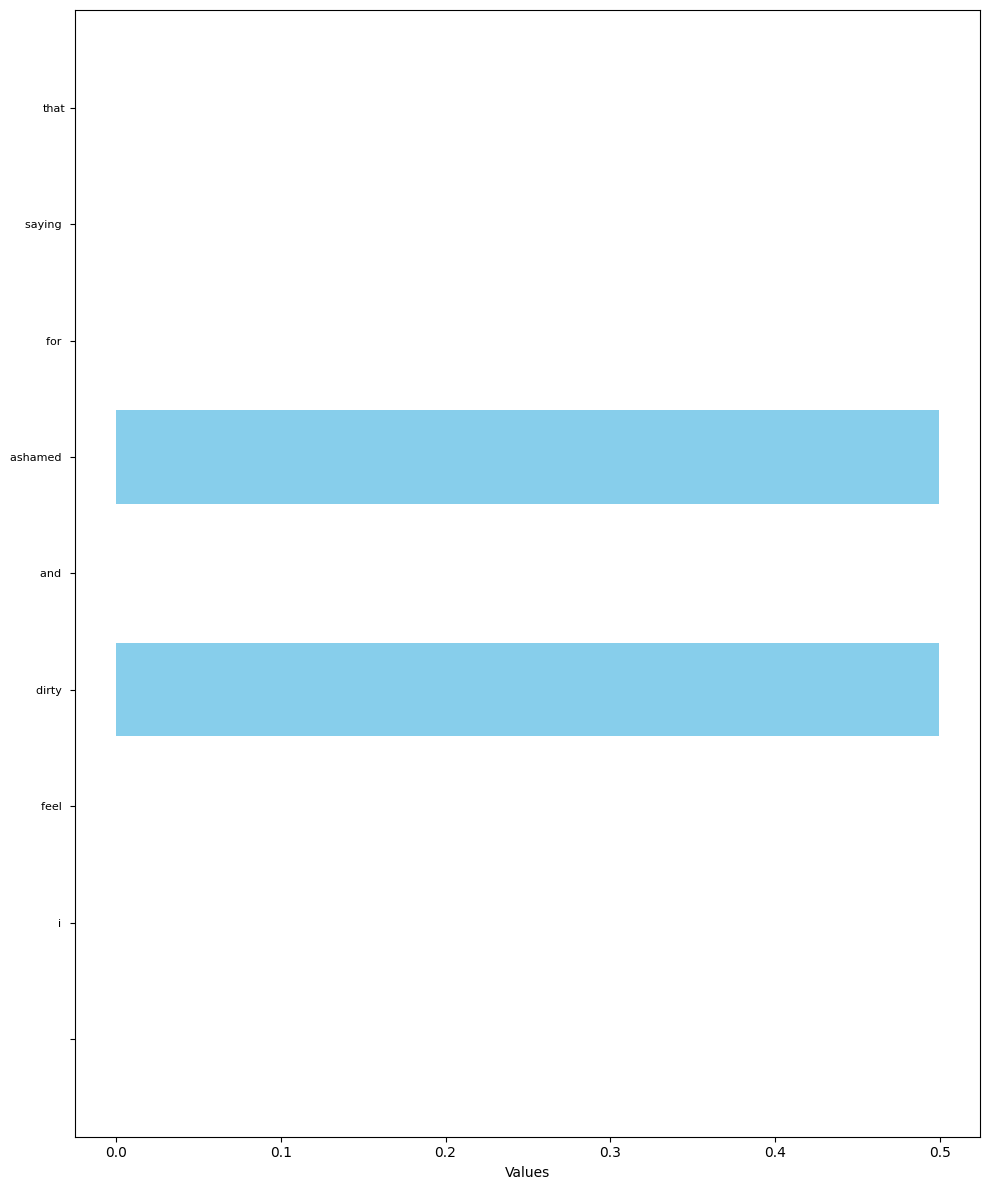

In [ ]:
for i in results:

    plot(i)



In [ ]:
def gen_output(d,p):

    t = 0.05

    val = d.values

    text = d.data

    f = f'The model predicted: "{p}" because of this set of words. The shap value in each words also given below\n'

    s = ""

    arr = []


    for i,j in zip(val,text):

        if(i >= t):

            s += j  + " {:.3f} ".format(i) + " "

        else:

            if(s != ""):

                s += "\n"

    f += s

    f = f.rstrip('\n')

    return f


In [ ]:
p = gen_output(results[2],preds[2])

In [ ]:
print(p)

The model predicted: "love" because of this set of words. The shap value in each words also given below
feel   0.228  like   0.233  
faithful   0.482  


In [ ]:
s = "\033[4m" + "eshasssssssssssssssss" + "\033[0m"

In [ ]:
print(s)

eshasssssssssssssssss


In [ ]:
preds[4]

'joy'